# Part one - defining the problem: class imbalance and knn

In [14]:
# handle imports
from pathlib import Path
import os
import sys
cwd = Path(os.getcwd())
prnt = cwd.parent
while prnt.parts[-1] != 'Proximal_ratio_knn-':
    prnt = prnt.parent

root = prnt.as_posix() 
sys.path.append(root)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import countplot, kdeplot, heatmap
from tqdm import tqdm


KNN models, specifically KNN classifiers, are exellent at predicting on balanced datasets. However, while I was trying to predict the length of stay from a dataset containing patient data, I found that my model's were performing poorly. Lets explore why.

In [16]:
# training dataframe from synthetic dataset
df = pd.read_csv(root + '/datasets/train_data.csv')


<Axes: xlabel='Stay', ylabel='count'>

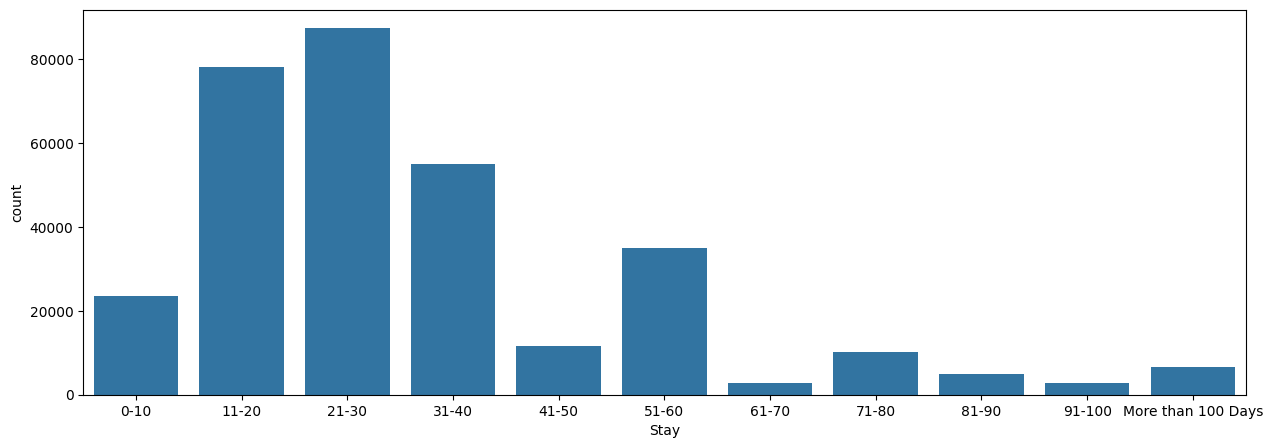

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
countplot(data=df, x=df["Stay"].sort_values(), ax=ax)

Taking a look at the training data, and specifically when looking at the target "Stay", we can see that Stay suffers from class imbalance, which will be a problem when using a classic KNN model. Let's explore why by training and testing a KNN model.

I have done EDA in much greater detail in the PRKNN_examples folder, where I discuss why I have dropped and transformed predictors in this way in EDA.ipynb.

In [18]:
def remove_fields(cols:list, columns_to_drop):

    cols2 = []

    for col in cols:
        if not col in columns_to_drop:
            cols2.append(col)
            # print(cols)

    return cols2

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_test = pd.read_csv(root + "/datasets/test_data.csv")

columns_to_drop = [
    "Hospital_region_code",
    "Ward_Facility_Code",
    "case_id",
    "patientid",
    "Hospital_code",
    "City_Code_Patient",
    "Admission_Deposit",
    # "Available Extra Rooms in Hospital",
    "Bed Grade",
    "City_Code_Hospital",
    "Visitors with Patient",
    "Hospital_type_code",
    # "Type of Admission",
    "Department"
]

df = df.drop(columns_to_drop, axis=1)
df = df.sample(10_000)

categoric_columns = [
    'Hospital_type_code',
    'City_Code_Hospital',
    'Department', 
    'Ward_Type',
    'City_Code_Patient', 
    'Type of Admission'
]

ordinal_columns = [
    'Bed Grade',
    'Severity of Illness'
]

cont_columns = [
    'Available Extra Rooms in Hospital',
    'Visitors with Patient',
    'Age',
    'Admission_Deposit'
]

categoric_columns = remove_fields(categoric_columns, columns_to_drop) 
ordinal_columns = remove_fields(ordinal_columns, columns_to_drop)
cont_columns = remove_fields(cont_columns, columns_to_drop)

X = df.drop('Stay', axis=1)
y = df['Stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state=33)

col_transformer = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(), categoric_columns),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns)
    ]
)

knn_pipeline_list = [
    ('col_transform', col_transformer),
    ('scaler', MinMaxScaler()),
    ('knn_imputer', KNNImputer(n_neighbors=10, weights='distance')),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
]

knn_pipeline = Pipeline(knn_pipeline_list)

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
np.unique(y_pred)

array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60'], dtype=object)

Just to summarise the above code, I dropped a large number of columns to remove irrelevant data such as patient ID, reduced the variance of the model, and avoided the curse of dimensionality before creating a pipeline that imputes and transforms the remaining features. I then split the data into training and testing sets, fitted the model, and predicted on the test set.

When we look at the unique classes in our predictions, we see that several lengths of stay are missing.

Just to make this clearer, below is a heatmap displaying the confusion matrix between y_pred and y_test. We can see that for the under-represented classes, we never made correct predictions, or any predictions at all.

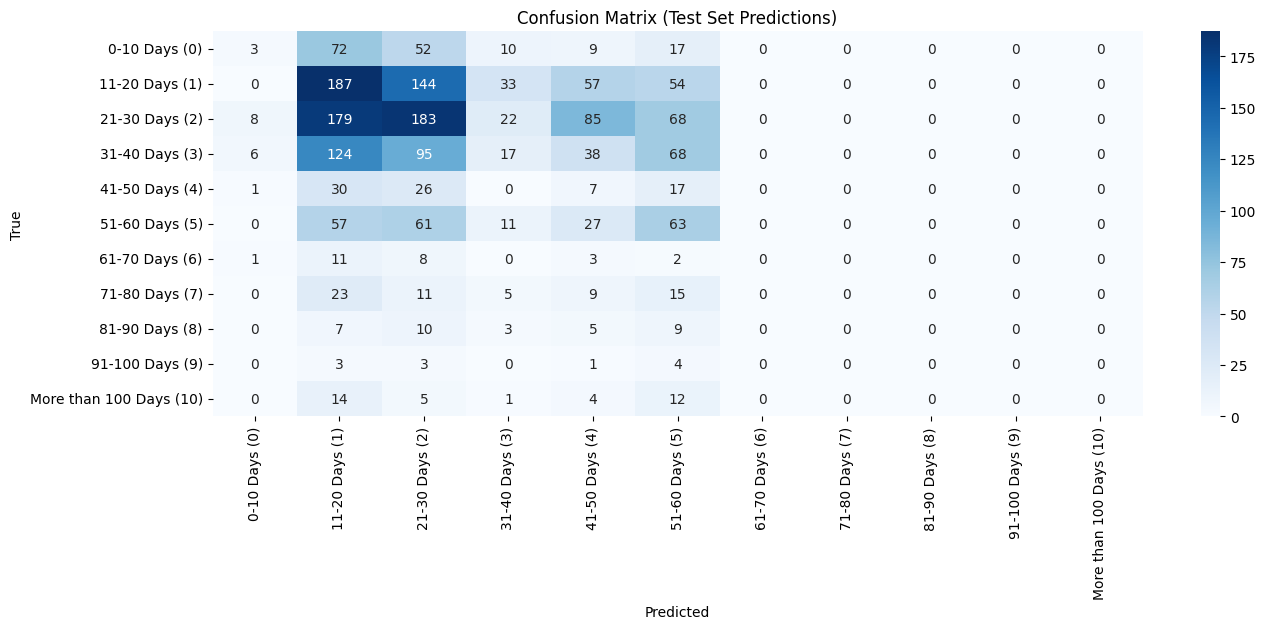

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_labels = [
    "0-10 Days (0)", "11-20 Days (1)", "21-30 Days (2)", "31-40 Days (3)",
    "41-50 Days (4)", "51-60 Days (5)", "61-70 Days (6)", "71-80 Days (7)",
    "81-90 Days (8)", "91-100 Days (9)", "More than 100 Days (10)"
]

# Visualize the confusion matrix with class labels
plt.figure(figsize=(15, 5))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set Predictions)')
plt.show()

While we are currently working with a synthetic dataset, this does show quite nicely one of the shortcomings of KNN models: predicting on unbalanced datasets.

In my research into how to solve this issue, I came across a paper titled "Effective k-nearest neighbor models for data classification enhancement" by Amer et al. (2025). This paper claimed to have successfully implemented KNN models that performed well on unbalanced data, so naturally, I decided to read further into their work.

# Part 2: A novel knn model

In the above paper, the authors discuss the various ways in which data can frustrate the performance of a KNN model, including class imbalance.

To solve this issue, they propose the use of a proximal ratio (PR) weighting scheme, which would, in theory, enable a KNN model to predict based on how an instance of a target class is clustered among other instances of its class, and make predictions accordingly.

### Calculating PR.

A PRKNN is actually two KNN models: one for calculating PRs, and the other for using those PRs for prediction.

To calculate each PR, each class is given a radius, which is simply the average pairwise distance in feature space between points in each class. It is worth noting here that while in this case Euclidean distance is used, other distances could be used, such as Manhattan (L1 norm), cosine distance, etc. This is something I plan to test in the future.

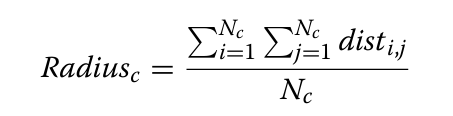

Once the class radius is calculated, the proximal ratio of each point is determined by dividing the number of nieghbouring points with the same label within the class radius of a given query by the total number of neighbours within that same radius. 

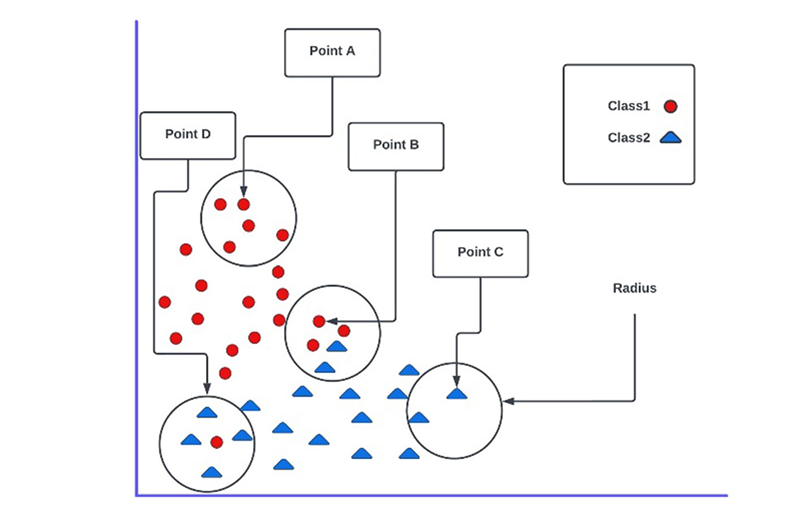
###### Amer et al (2025)

How these proximal ratios are used during prediction depends on the type of PRKNN model, of which there are three: standard, weighted, and enhanced.

The standard model divides point PRs by their distance to a prediction query to produce class-wise weights, while the enhanced version only uses PRs. The weighted model combines three weights: first, the average inverse distance to the query; second, the number of points of the class label divided by k; and third, the average of distances scaled between 0 and 1 based on the minimum and maximum distance from the query.

I have to admit, by this point I feel the paper becomes unclear regarding the third weight. Initially, they present the equation below (Eq. 11):
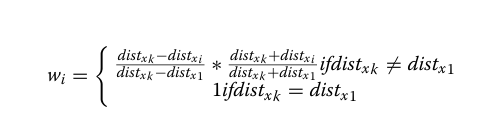 
###### Amer et al (2025)

However, when they re-outline steps for the weighted PRKNN, they refer to this equation (Eq. 6) for the third weight:

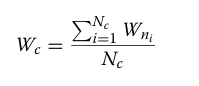
###### Amer et al (2025)

As a result, I cannot say with confidence that I have implemented the weighted PRKNN as the researchers did. Since Eq. 11 was presented first, I decided to use that, even though it means that PRs are not used at all in this PRKNN.

I have other complaints about this paper, including whether the k parameter should be shared across the PR-calculating and prediction KNN models (I have assumed that they are below), as well as how divisions by zero should be handled when calculating weights.

# Part 3: Testing PRKNN

To see whether my implementation was the same as the authors’, I tried to replicate Experiment 1 of the paper. This involved 10-fold cross-validating all three versions of the model against 14 of the datasets the authors used, with k values of 5, 15, 30, and 45. I recorded the average F1-scores for each k value and compared them to their results.

It should be noted that the authors use macro-F1. I have computed micro, macro, and weighted F1 for additional insight.

I also cannot find any details regarding data preprocessing in the paper, so I have run my replication of Experiment 1 without it.

![alt text](assets/exp1macro.png)

My F1 scores are different to those from the paper accross all similar datasets. I have a few ideas as to why:
- for all models, the way in which divisions by 0 are handled are not explcitley stated in the paper. For example:
    ```python
    with np.errstate(
            divide="ignore"
        ):
            if version == "standard":
                ww = self._proximal_ratios[indexes] / dd
            elif version == "enhanced":
                ww = self._proximal_ratios[indexes] 
            elif version == "weighted":
                ww = dd
    ```

In this snippet, I calculate the neighbour weights for each query point. Notice that for the standard version, the weight is calculated by
dividing the neighbour proximal ratio by its distance from the query (dd), which could, in theory, be 0. While collisions like this aren't common, they do need to be handled, and the paper gives no details as to how they did it!

I opted to replicate what scikit-learn's KNN model does: divisions by zero evaluate to np.inf, which is a valid argument for np.argmax().

For the standard model:
    
    ```python
    y_pred[query_index] = fitted_classes[np.argmax(class_weights)]
    ```

- The authors do not specify whether they completed any preprocessing prior to testing. 
- We cannot be completely sure they have even accurately described their models
    Quite the allegation! But there are a few reasons why I have this concern:
    - They give multiple, inconsistent definitions for the weighted PRKNN model
    - For the enhanced model, one of the steps "Find k neighbors $N_q$ and their distance values $dist_q$", despite saying beforehand that the 
        enhanced model "... only used the average proximal ratios to compute the class weights and
        did not consider the distance."

    The above leads to suspect that the authors were not careful in ensuring their model descriptions were accurate, and I therefore believe them to be unreliable.


- I implemented their model(s) incorrectly
    While I tried my best to follow the steps the authors outlined, there are many places where mistakes would effect the model's results.


# Part 4: Implementation challenges

By far the hardest part of this project was calculating the class radii as part of calculating proximal ratios.

As a reminder, class ratios are the average pairwise distance between the points of each class. The number of pairwise distances is given by 
$$
nCr2 = \frac{n!}{n!(n-2)!}

$$

which quickly becomes an issue when calculating for large numbers of points. Looping is too slow, and vectorization requires too much memory when working with large datasets. The solution was to employ chunking, calculating the distances in smaller, but still vectorized groups, before calculating the total mean.